# DSC 80: Project 01

### Due Date: Thursday, 2018-01-24 12:00:00 (Noon)

---
# Instructions

This Jupyter Notebook contains the statements of the problems and provides code and markdown cells to display your answers to the problems.  
* Like the homwork, your coding work will be developed in the accompanying `project01.py` file, that will be imported into the current notebook. This code will be autograded.
* The project also has free response questions. To answer the free response questions, edit the markdown cell where specified (as in DSC 10). Submission of the project include uploading a pdf of this notebook to gradescope for manual grading.

**Do not change the function names in the `*.py` file**
- The functions in the `*.py` file are how your assignment is graded, and they are graded by their name. The dictionary at the end of the file (`GRADED FUNCTIONS`) contains the "grading list". The final function in the file allows your doctests to check that all the necessary functions exist.
- If you changed something you weren't supposed to, just use git to revert!

**Do not change the free response cells outside the horizontal lines**
- The format of the cells will be used in grading the free response questions.


**Tips for developing in the .py file**:
- Do not change the function names in the starter code; grading is done using these function names.
- Do not change the docstrings in the functions. These are there to tell you if your work is on the right track!
- You are encouraged to write your own additional functions to solve the HW! 
    - Developing in python usually consists of larger files, with many short functions.
    - You may write your other functions in an additional `.py` file that you import in `hw01.py` (much like we do in the notebook).
- Always document your code!

**Tips for writing the free response questions**:
- You should treat the notebook as a final report for the assignment, containing conclusions and answers to open ended questions that are graded.
- Upon submitting the notebook, there should not be extraneous code in the notebook (e.g. any debugging code). You should only have your answers the the questions, and the necessary code and corresponding output data that serves as evidence for your responses.
- Generally, the free response questions will involve you *using* the functions defined in your `.py` file to justify portions of your argument.
- They should not be long, verbose answers! Typically a short paragraph will do.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import project01 as proj

---
# Part 1: The CSV Format

CSV data is a very common data format for storing tabular data. However, csv data suffers from various shortcomings, among them being that *[it's not well defined what csv data actually is](https://en.wikipedia.org/wiki/Comma-separated_values#Specification)!*. Most of the trouble comes from two sources:
1. If a field contains an instance of the delimiter, you have to differentiate between the character in the field and a delimiter itself. This is typically done using a *quote character*. For example if comma is the delimiter, and a field contains a comma, then we could say that any instance of a comma between two quotes is part of the entry and isn't a delimiter.
2. If we've specified a quote character, then we also need to differentiate between a quote character and an instance of that character as an entry in a field. This is usually handled by defining an *escape character*.

The most common values for these are:

|||
|---|---|
|delimiter|,|
|quote character|"|
|escape character|\|

Using these values, given the table:

|Last Name, First Name| Favorite Character(s)|
|---|---|
|Doe, John|,|
|Doe, Jane|"|
|Doe, Joan|\|
|Doe, Josh|",|

Would produce a csv file with the following lines:

```
"Last Name, First Name", Favorite Character(s)
"Doe, John",","
"Doe, Jane",\"
"Doe, Joan","\"
"Doe, Josh","\","
```

An in depth description is found on [wikipedia](https://en.wikipedia.org/wiki/Comma-separated_values#Basic_rules).

### `pd.read_csv` and malformed csv

The primary way we will read in tabular data is using the pandas `read_csv` function. This function has *many* options to account for all of the ways data may have been written to file. The most important keyword arguments for enabling the parsing of the basic structure of csv files are:
1. `sep`: the delimiter of the file.
2. `quotechar`: the character used to 'quote' an instance of a delimiter in an entry.
3. `quoting`: whether to search for quoted delimiters or not.
5. `escapechar`: what character should be used to escape quotes in fields.
6. `skiprows`: skip the first few rows of a file (useful if they're weird).
7. `nrows`: only read in the first few rows (useful if a line is bad later in the file).

See the documentation for further details (evaluate the cell below). The `read_csv` function changes not infrequently. Even its default behavior changes, meaning a csv-file written by Pandas a few years ago may not read in properly by default using the current Pandas implementation!

In [ ]:
import io
import pandas as pd
help(pd.read_csv)

### CSV debugging pro-tip: `StringIO`

[`StringIO`](https://docs.python.org/3/library/io.html#io.StringIO) is a class in the `io` module that allows you to work with in-memory text streams. `StringIO` creates an object similar to a file handle (created by `open`) via a string, that lets you "fake" a file handle, which is handy for testing. Read more about the io library from the [documentation](https://docs.python.org/3/library/io.html)

In [ ]:
my_csv_text = '''header1,header2,header3
1,2,3
4,5,6
a,4,
'''
print(my_csv_text)

You can then define a StringIO object with this string and work with it as if it were a file opened on disk:

In [ ]:
fh = io.StringIO(my_csv_text)
pd.read_csv(fh)

In [ ]:
fh = io.StringIO(my_csv_text)
pd.read_csv(fh, nrows=2, usecols=['header1', 'header3'])

Now, we will compare the process of:
1. 'properly' parsing a csv file, being careful about quoted delimiters and
2. disregarding quoting, merely splitting lines based on a delimiter.

Unsurprisingly, option 2 is much faster. One strategy of data processing is to carefully process a csv file once, and rewrite the file as a csv using a delimiter that's *guaranteed not to be found* in the entry (for example, [Control Characters](https://en.wikipedia.org/wiki/Control_character)). Thus, future readings of the file can split on delimiter without worry. This technique is used by many big data tools (e.g. [Apache Hive](https://en.wikipedia.org/wiki/Apache_Hive)).

**Question 1 (Split, Not Parse):**

Create a function `split_on_delim` which takes a file object or StringIO stream and returns a list-of-lists. Each list is a line that has been split into entries by the delimiter. Each entry should be a string. `split_on_delim` should also have the keyword argument `delimiter` with default value `,`.

```
>>> s1 = io.StringIO('1,2,3,4,5')
>>> split_on_delim(s1)
[['1', '2', '3', '4', '5']]
>>> s2 = io.StringIO('1,2,"3,4",5')
>>> split_on_delim(s2)
[['1', '2', '"3', '4"', '5']]
```

**Question 2 (Reading malformed csv files):**

`malformed.csv` contains a file of comma-separated values, containing the following fields:

|column name|description|dtype|
|---|---|
|first|first name of person|str|
|last|last name of person|str|
|weight|weight of person (lbs)|float|
|height|height of person (in)|float|
|geo|location of person (lat, long)|str|

Unfortunately, the entries contains errors that cause `read_csv` fail to parsing the file with the default settings. 

Clean the csv file into a Pandas DataFrame with columns as described in the table above, by creating a function called `parse_malformed` that takes in a *file handle* and returns the parsed, properly-typed Pandas DataFrame.

*Hint:* Read in the file using `open` and clean the fields using basic python. Peek at the format of the file and use the fact that you can infer what the columns contain!

*Note:* Assume that the given csv file is a sample of a larger file; you will be graded against a **different** sample of the larger file.

In [ ]:
# watch this break! try to fix it!
pd.read_csv('malformed.csv')

**Question 3 (DIY CSV Parser):**

In this question, you will create your own basic csv-parser. This exercise is useful, as you may find yourself implementing variations of such a parser when dealing with larger corrupted csv files for which off-the-shelf parsers fail and you cannot possibly fix the files by hand.

Create a function `parse_csv` which takes a *file object* or *StringIO stream* and returns a list-of-lists that represents parsed csv. The output should handle the following requirements:

* The function should have the following keyword arguments:
    - delimiter (one-character string, default `,`): the delimiter for the csv file.
    - quotechar (one-character string, default `^`): the quote character that handles the entries that contain the delimiter.
    - escapechar (one-character string, default `_`): the escape character specifies when a character should be iterpreted literally, as opposed to a csv character with special meaning.
    
    
* If an entry contains a delimiter, then that entire entry is enclosed in the quote-character:
    - if `quotechar='^'`, then a line with a quoted entry looks like `1,2,^hi,there^,7`.
* If a quoted entry contains an instance of the quote-character, then that quote-character is preceded by the *escape-character*:
    - if `escapechar='_'` and `quotechar='^'`, then a line with a quoted entry looks like ```1,2,^my emoji, _^@_^^,7```.
* The parser should be able to handle new-lines in entries.
    - *Note*: in this case, a single line of csv will be broken into more than one line in the file!
* The parser should *not* infer data types (all entries are strings).
* Each line *may* have different number of fields (unlike `read_csv`).

Partial credit will be given along the following guidelines, which should guide your work:
* Your function handles parsing delimiters without handling quoting correctly (checkpoint 1)
* Your parser works as stated when there are no quote-characters or newlines in quoted fields. (checkpoint 2)
* Your parser works as stated when there are no new-lines in quoted fields. (checkpoint 3)
* Your parser works as stated in the problem. (finished)


Note, `parse_csv` is *roughly* equivalent to:
```
pd.read_csv(file, escapechar='_', quotechar='^', doublequote=False, header=None, dtype=str)
```
which may help testing your function.

The following doctests help illustrate how `quotechar` and `escapechar` work.

* Quoted delimiter:
```
>>> s1 = io.StringIO('1,2,^hi,there^,7')
>>> parse_csv(s1)
[['1', '2', 'hi,there', '7']]
```

* Quoted quote-character:
```
>>> s2 = io.StringIO('1,2,^my emoji, _^@_^^,7')
>>> parse_csv(s2)
[['1', '2', 'my emoji, ^@^', '7']]
```

* Quoted escape-character (escape the escape!):
```
>>> s3 = io.StringIO('1,2,^my emoji, _^___^^,7')
>>> parse_csv(s3)
[['1', '2', 'my emoji, ^_^', '7']]
```

* Quotes not near a comma don't matter!
```
>>> s4 = io.StringIO('1,2,,this field has ^quotes^,7')
>>> parse_csv(s4)
[['1', '2', 'this field has ^quotes^', '7']]
```

*Note on choice of default values:* We are using non-standard values of quotechar/escapechar in this problem, largely because it actually makes it easier to test and debug. In particular the two standard choices for escapechar can be very confusing to develop with:
1. `\` is the same as the escapechar for all python strings, so when entering the character via python code, you would always have to *double-escape*!
2. `"` is the same as the standard quotechar, which obfuscates the different role the characters play.

**(Optional: Performance testing):**

* Compare the speed of `split_on_delim` and `parse_csv` using `%timeit` -- how much faster is the first function?
* You can also turn off quoting in `pd.read_csv` using `quoting=3`, which speeds up the parsing. Compare the speed of that option with your `split_on_delim`.
* Note, that Pandas `read_csv` is actually implemented in C++, while many basic python methods are implemented in C.

---
# Part 2: SDPD Vehicle Stops 

This section will explore the San Diego Police Traffic Stops dataset for the year of 2016. Information about the data is available [here](https://data.sandiego.gov/datasets/police-vehicle-stops/). According to the city of San Diego website, the dataset contains
> Vehicle stops made by the San Diego Police Department. [The] Vehicle Stops files contain all vehicle stops for a given year.

The dataset is purportedly a *census* -- i.e. it contains *every* vehicle stop (and not just a sample) in a given year.

The description of the fields from the source can be found here:

In [ ]:
sdpd_description = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_dictionary.csv')
sdpd_description

You can download the file directly here:

In [ ]:
sdpd = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_2016_datasd.csv')
sdpd.head()

In the following problems, we'll be concerned with the following fields:
```
stop_id, service_area, sd_resident, searched, obtained_consent, contraband_found, property_seized
```
First, we'll assess these fields for data reliability.

---

**Question 4 (Assessment of `stop_id`):**

The stops data dictionary describes `stop_id` as being a 'unique stop identifier'. However, messy data often defies expectations about the meaning of a field. In this dataset, it turns out the `stop_id` field is not unique.  It's up to you to figure out why this may be the case, and whether it will be a problem for your analyses.

1. Create a function `basic_stop_id_stats` that takes in a dataframe like `sdpd` and returns a Pandas Series containing the data below (the indices for each entry are given in parenthesis after the description):
    - The total number of records in the input data (`total_records`).
    - The number of unique `stop_id`s in the input data (`num_unique`).
    - The number of `stop_id`s that have multiple records associated to them (`ids_with_duplicates`).

*Hint:* Use a dictionary with the above quantities to define your series!
    
2. Create a function `get_duplicates` that takes in a dataframe (that has a column `stop_id`) and returns a dataframe consisting of only those rows whose `stop_id` is associated with multiple records. Additionally, the returned dataframe should be sorted by `stop_id`.

In the next question, you will use the functions above on the `sdpd` dataframe to draw conclusions.

**Question 5 (Assessment of `stop_id` conclusion):**

You must now make a decision on how to deal with duplicate `stop_id`s. You generally have three choices:
1. Conclude that the multiple rows corresponding to a single `stop_id` are in fact the same "real event" and drop the duplicates, keeping only one event.
2. Conclude that the `stop_id`s that appear multiple times actually have no relation to each other and consider making your own unique identifier (e.g. based on the index).
3. Decide there isn't enough information to make a deicision and that the impact of a wrong decision would significantly impact your understanding of the dataset. In this case, you need to better research the data generating process.

Which of these choices would you make in this case? You should support your answer using specifics from the data; be sure to address the severity of the problem, as well. Your work in the previous question will help!

Do your supporting data analysis in the cells below (add them as you need) and write your free response answer in the markdown cell below, between the lower of the two horizontal lines. **Do NOT change the free-response markdown cell outside the two horizontal lines!**

**Free Response Area: Question 5 (Assessment of stop_id conclusion):**

---

WRITE YOUR RESPONSE HERE

---

---

## Geographical Fields in the Vehicle Stops Data

There are two geography-related fields in the stops data: `service_area` and `sd_resident`. In this section, we will assess the reliability of these two fields and understand some basic properties of them.

The column `service_area` denotes the police service areas, which split San Diego into patrol regions.

In the map below:
1. The 3 digit codes correspond to *police beats*.
2. Taking the first two digits of these codes gives *service areas* (this is in our data).
3. Taking the first digit of these codes gives the *division* (marked by colors in the map).

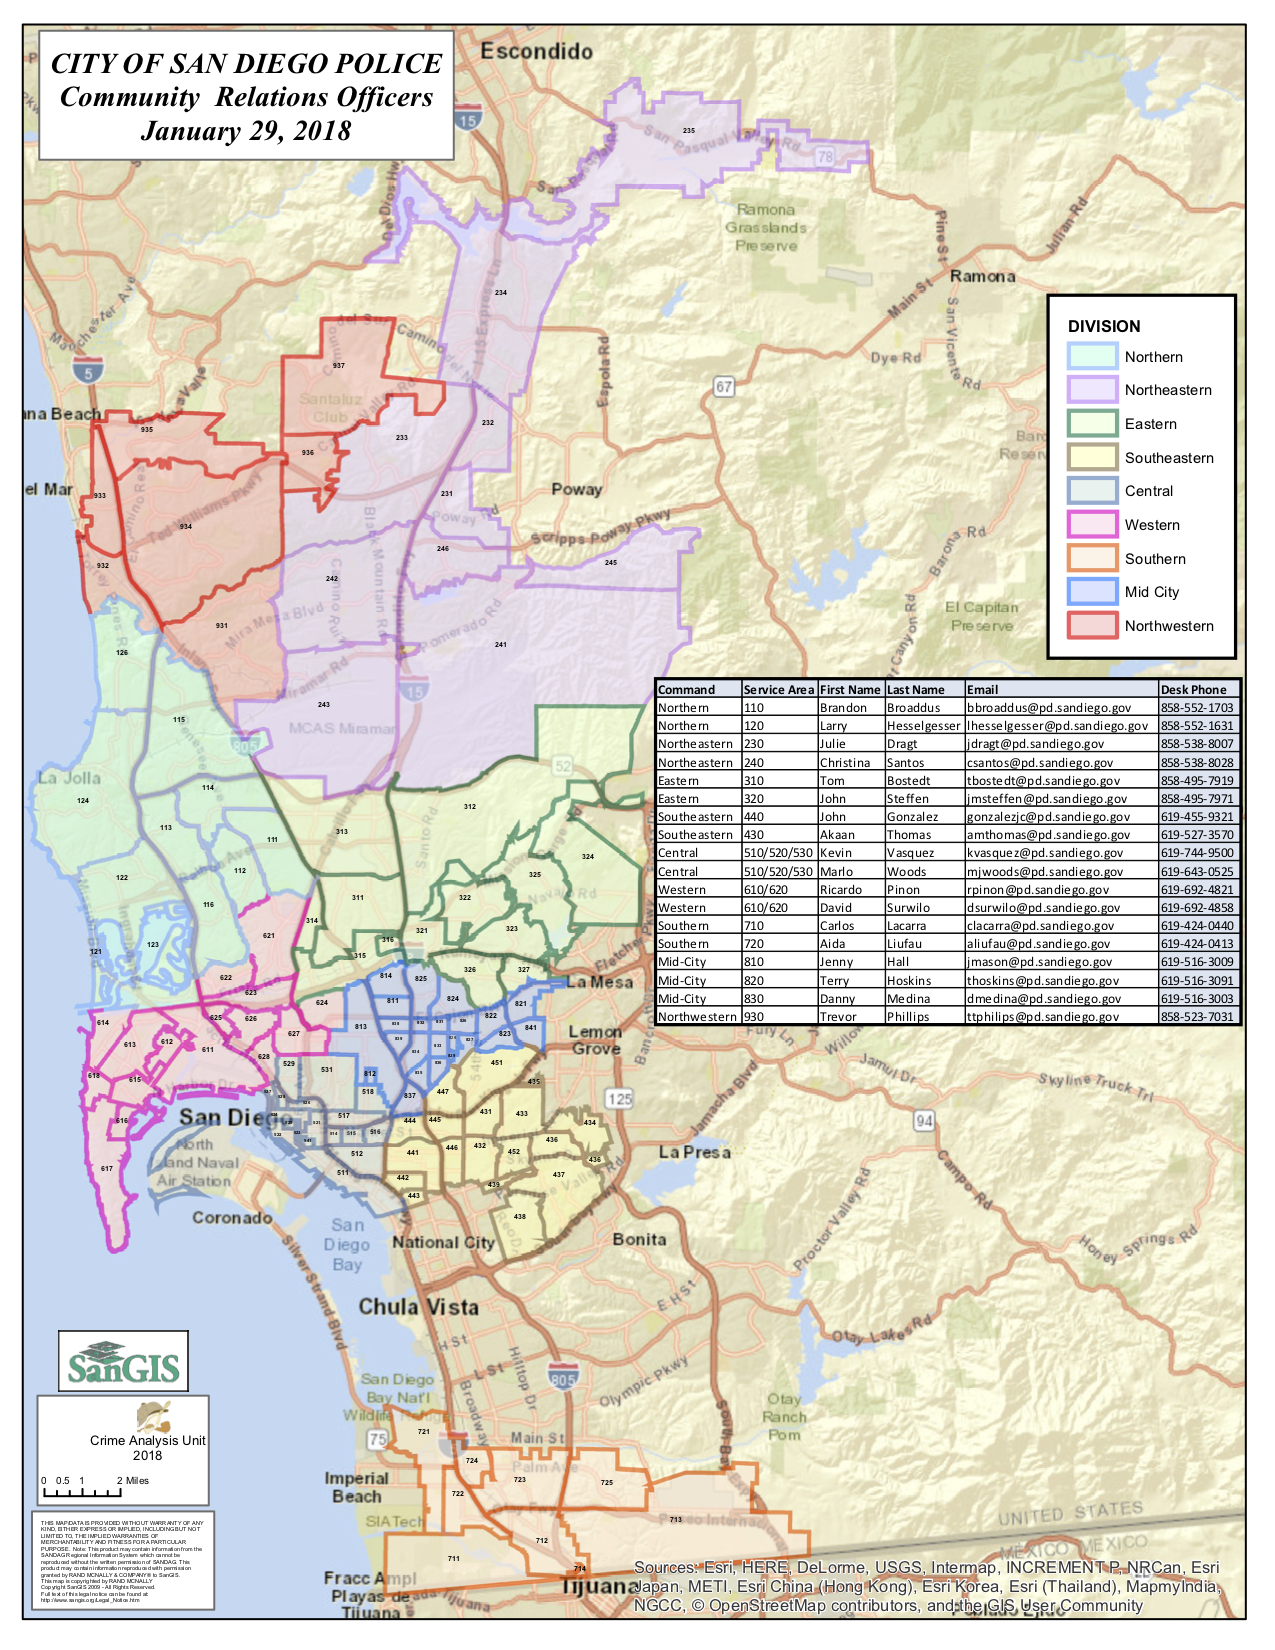

**Question 6 (Basic `service_area` properties):**

The `service_area` field should have dtype object upon reading in the dataset, as there are strings mixed with integers in the column. However, there are also no null values (verify these statements!). In this question, you will clean `service_area` column.

Create a function `service_area_props` that takes in a dataframe like `sdpd` and returns a list with the following quantities in the following order. If the problem is multiple choice, give your answers as `int`s (1,2,3).

* What kind of data is `service_area`?
    1. quantitative
    2. ordinal
    3. nominal
* What proportion of the stops had a `service_area` that's not of an integer form?
* Which data type listed below is most appropriate for a cleaned `service_area` column?
    1. `str` / `object`
    2. `int64`
    3. `float64`
    
*Note:* This is a hacky way to just return a list of values that can be autograded. Your function will just return a hard-coded list of answers.

**Question 7 (`service_area` cleaning and `division`):**

Assume that any `service_area` entry that can't be made an an integer should be replaced with the value `NaN`.
1. Create a function `clean_service` that cleans the `service_area` column as described above.
2. Create a function `create_division` that takes in a (cleaned) service area and returns the division.
3. Create a function `geo_stops` that takes in the `sdpd` dataframe and returns a dataframe with the following columns:
    - a column `service_area` that has been cleaned using `clean_service`.
    - a column `division` (using `create_division`). 

Be sure `geo_stops` doesn't have any side effects! (i.e. it shouldn't change `sdpd` -- the dataframe method `.copy()` should be helpful).

In [ ]:
# geo_stops(sdpd)

**Question 8 (Null values in `sd_resident`):**

Next, we want to clean and understand the null values in the `sd_resident` field and understand how it relates to the `service_area` field. Create the following functions and use them to understand the field:
- Create `clean_sd_resident` which converts the `sd_resident` column to boolean type via the method `.apply`. Be sure to handle messy data appropriately.
- Create `resident_place_cnts` which takes in a dataframe like `sdpd` and returns a dataframe whose:
    - rows are indexed by `service area`,
    - columns are values of `sd_resident`, and
    - the entries are the proportion of traffic stops in each `service_area` that happen to each value in `sd_resident`. 
    - Don't forget to include null values for `sd_resident`.  
    - You should use *cleaned* `service_area` and `sd_resident`.
    - *Hint:* the crosstab function should be useful.

**Question 9 (Null values in `sd_resident` part II)**

We'd like to assess if we can infer the null-values of `sd_resident`, or safely drop them. To do this, we must try to undestand the meaning of the null values. Describe a possible scenario for how the null values came about (in terms of the data generation process -- i.e a traffic stop). Your answer should address the following:
- What is the proportion of values of `sd_resident` that are null? 
- Do you think null values in `sd_resident` are stand-ins for Yes/No? (e.g. could we replace NULL with Y?)
- How are the null values for `sd_resident` different than `Unkown` for `service_area`? Who is creating the information in each of these fields?

**Free Response Area: Question 9:**

---

WRITE YOUR RESPONSE HERE

---

**Question 10 (Null values in `sd_resident` part III):**

Next, in assessing how to handle the null-values of `sd_resident`, we need to understand if the field is missing completely at random (MCAR), missing at random (MAR), or not missing at random (NMAR). Below, make a case for the possibility of each being true; if you think one is highly unlikely, say so. Back up your arguments with data (you may find your function `resident_place_cnts` useful) and reference to the process that generated the data.

**Free Response Area: Question 10 (Null values in `sd_resident` part III):**

---

WRITE YOUR RESPONSE HERE

---

**Question 11 (Search/Arrested Fields):**

Consider the four fields: `searched, obtained_consent, contraband_found, property_seized`.

According to the data dictionary for these fields:

|field|description| possible value|
|---|---|---|
|searched|if a search was conducted|Y/N|
|obtained_consent|if a search was conducted, if consent was obtained|Y/N|
|contraband_found|if a search was conducted, if contraband was found|Y/N|
|property_seized|if a search was conducted, if property was seized|Y/N|

These fields should be consistently null dependent on the value of the `search` column. We'd like to investigate the quality of the data dictionary in this context.

* Create a function `clean_search_columns` that takes in the `sdpd` dataframe and outputs a *copy* of the dataframe with the same columns.  Each of the four columns in the table above should be cleaned -- each column should contain only three possible values: booleans and `NaN`. You should make the best decision on cleaning dirty values, and the clean columns should have the same name as the dirty columns.

**Optional:**

True to understand the extent to which the missingness of these fields depend on the `searched`. When searched is True, do the other fields tend to be non-null? Are they every non-null when `searched` is null or False?

Use the following table to try to answer these questions.

In [ ]:
(
    data.fillna('NULL')
    .groupby('searched obtained_consent contraband_found property_seized'.split())
    .size().reset_index()
)

# Congratulations, you finished the project!

### Before you submit:
* Be sure you run the doctests on all your code in project01.py
* Be sure your free repsonse questions are all answered, readable, and that you haven't changed the cells outside the horizontal lines!

### To submit:
* **Convert the notebook to PDF and upload to gradescope.**
* **Zip up your project01 directory and upload it to the autograder.**